# Introduction

They say deep learning is a black-box; which in my honest opinion is true to some degree but I would like to rethink this. After going through [fastbook chapter 13](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb), I think we are not so helpless when it comes to understanding what the deep learning neural networks are going through and one such tool that we'll discuss here is **activation analysis**.

Activations are simply what we get after we pass the input through any network layer (be it conv/linear/convtranspose etc.). Understanding these activations can help us get a sense of the training process of the network i.e. is the training stable, where did it go haywire, how sensitive is it to the outliers etc. We shall perform a simple experiment to demonstrate this process through the rest of this post and in the process also look at the callback functionality of fastai which makes life so much easier when you want to do something in the middle of training.

- [Basic CNN]()
- [Callbacks for activation logging]()
- [Understanding activations]()
- [Activations analysis to interpret model training]()

# Basic CNN

In this section, we shall build a simple cnn that we shall use to train an MNIST digit classifier [0-9]. This is already provided as a part of fastai (for the first time, it will download it from an aws public resource but then it will be saved on your disk in your root/home directory in a folder `.fastai`).  

In [1]:
# Import the necessary libraries
from fastai.vision.all import *
from fastai.callback.hook import *
import seaborn as sns

# Download the dataset/reference it if already downloaded
path = untar_data(URLs.MNIST)

Now that we have the path to our dataset, let's create a datablock to load the dataset into batches as a dataloader. There's close to **6k images per class** which means **60k** total images. Out of these, let's set 25% aside for the sake of validation. This leaves us with 75% for training which is still substantial for the task at hand.

In [2]:
dblock = DataBlock(
                    # Input will be image, output is a category. Convert the 
                    # input to be a black and white image from a color image
                    (ImageBlock(cls=PILImageBW), CategoryBlock),
                    # The input can be read through the folder as all of them image files are in
                    # a single folder in the imagenet structure
                    get_items = get_image_files,
                    # Since images are in the imagenet structure, one level above the image location
                    # should be a folder that's eponymous to the category pertinent to that datapoint
                    get_y = parent_label,
                    # Randomly split the images into train/valid & set seed for reproducibility
                    splitter = RandomSplitter(valid_pct = 0.25, seed = 42),
                   )

dls = dblock.dataloaders(path/"training", batch_size = 64)
len(dls.train), len(dls.valid)

(703, 235)

Any convolutional network is made of conv blocks. These conv blocks are most of the time a combination of 

$$ Conv2d \rightarrow BatchNorm \rightarrow Activation(ReLU) $$

Let us create a function that makes such blocks for us and then define a cnn which is made of a sequence of such blocks.

In [3]:
def make_conv_block(input_channels: int, output_channels:int, kernel_size:int = 3, 
                    stride:int = 2, padding:int = None, 
                    act:bool = True, batch_norm:bool = False) -> nn.Sequential:
    """
    Create convolution blocks given channel config, kernel size, stride, padding and finally
    whether or not to apply batchnorm and a non-linear activation (ReLU)
    """
    if not padding: padding = kernel_size // 2

    c = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding = padding)
    layers = [c]
    if batch_norm: layers = [c, nn.BatchNorm2d(output_channels)]
    if act: layers.append(nn.ReLU())

    return nn.Sequential(*layers)

In [4]:
def basic_cnn_model(bn:bool = False)-> nn.Sequential:
    """
    Create a simple CNN model which reduces eventually to a 1 x 1 activation
    Assume the input size is 28 x 28
    """
    c_block1 = make_conv_block(1, 8, kernel_size = 5, batch_norm = bn)      # 14 x 14
    c_block2 = make_conv_block(8, 16,  batch_norm = bn)                     # 7 x 7
    c_block3 = make_conv_block(16, 32,  batch_norm = bn)                    # 4 x 4
    c_block4 = make_conv_block(32, 64,  batch_norm = bn)                    # 2 x 2
    c_block5 = make_conv_block(64, 10, batch_norm = False, act = False)     # 1 x 1
    return nn.Sequential(*[c_block1, c_block2, c_block3, c_block4, c_block5, Flatten()])

In [5]:
model = basic_cnn_model().to("cuda")
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(full=False)
)

In order to understand the model activations it's best if we look at the progression of a mini-batch through these model layers. So let's do that and see what we get.

In [6]:
# Get a training batch
xb, yb = dls.one_batch()
activations = []

# Pass the batch through each layer and see the output shapes
print(f"{'Input Shape':<14}: {str(xb.shape):<27}")
for idx, layer in enumerate(model, start = 1):
    with torch.no_grad():
        xb = layer(xb)
        print(f"Layer {idx} output: {str(xb.shape):<27}")

Input Shape   : torch.Size([64, 1, 28, 28])
Layer 1 output: torch.Size([64, 8, 14, 14])
Layer 2 output: torch.Size([64, 16, 7, 7]) 
Layer 3 output: torch.Size([64, 32, 4, 4]) 
Layer 4 output: torch.Size([64, 64, 2, 2]) 
Layer 5 output: torch.Size([64, 10, 1, 1]) 
Layer 6 output: torch.Size([64, 10])       


 In every successive pass of the model, we see
 
 - Number of channels are doubled
 - Spatial dimension of the feature maps are reduced
 
This is characteristic of most CNNs because we want to extract rich features from the previous layer and the successive layers have a larger receptive field thanks to the compunding effect from the previous layers. For the first part i.e. extraction of rich features, we increase the number of output channels as those correspond to features. We reduce the spatial dimension to reduce compute (convolutions over wider and longer matrices can become very expensive) and since we already know the compounding effect of receptive field ensures we're not losing out on the spatial dimensions.
 
Eventually we get 1 x 1 activation map that is flattened to get a 64 x 10 output. 10 because we have 10 classes i.e. 0-9.

Since we're all set with our model now, we need to make sure we log the activations i.e. output from each of these small individual conv modules. `fastai hooks` and a very convenient `callback` mechanism has us covered for performing this task. Let's take a look at it in the following section.

# Callbacks for activation logging

![](./images/callbacks.png)

If we want to perform any operation like logging, transformation, versioning etc. of our models/data/output at different points in the training process, we can use the above class to do so. The methods above do stuff just like they sound. To name a few,

- before_fit: If you want to initialize something before every fit or fit_one_cycle call, override this function
- before_epoch: If you want to initialize or do some computation before a new epoch starts, override this function.
- after_batch: If you want to do something after every batch has been processed through the neural network, override this function.

Similarly there's a lot of other things like you may want to do something before validation pass begins or after the training ends or before the next epoch begins. All you need to do is simply inherit from the `Callback` class and create a subclass and override those methods eponymous with the task that you want to perform at different points in an input tensor's journey through the neural network. In order to log activations, we need to create hooks for the required layers on our model *before fitting* and after every batch, *store the activations to a list/container*.

A hook is as the name suggests a data structure to store the activation *(result of the forward pass)* through a layer as a batch of inputs progresses through it. We can selectively choose to add hooks to the layers that we are interested in using `hook_output` method or for the entire model can be hooked using the `hook_outputs` method which is implemented in fastai for our convenience. 

For an in-depth explanation on callbacks, refer the [fastai documentation on callbacks](https://docs.fast.ai/callback.core.html). For more details on the `hook_output/s` functions refer the [hook_output documentation](https://docs.fast.ai/callback.hook.html#hook_output).

In [13]:
class activation_logging(Callback):
    
    def before_fit(self):
        # Before start of training, initialize a dictionary to store all the activations for several layers
        # In a hooks list, store the hooks for which you want to get the activations
        self.learn.activations = {}
        self.learn.hooks = []
        self.learn.batch_count = 0
        
        # Our model is a series of sequential layers the first entry of which is a conv layer
        # We want to log the activations obtained from these conv layers
        for idx, layer in enumerate(self.learn.model):
            if isinstance(layer, nn.Sequential):
                self.activations[f"layer_{idx}"] = []
                self.hooks.append(hook_output(layer[0]))
    
    def after_batch(self):
        # Log the output of every conv layer in our model
        if self.learn.batch_count < len(learn.dls.train):
            for idx, layer in enumerate(self.learn.model):
                if isinstance(layer, nn.Sequential):
                    self.learn.activations[f"layer_{idx}"].append(self.learn.hooks[idx].stored.to("cpu"))
        self.learn.batch_count += 1
    
    def after_epoch(self):
        self.learn.batch_count = 0

In [14]:
# Instantiate a learner with the above callback and train for some epochs
learn = Learner(dls, basic_cnn_model(bn = True), 
                loss_func=F.cross_entropy, 
                metrics=accuracy, 
                cbs = activation_logging())

learn.fit_one_cycle(5, lr_max = 6e-2)    

epoch,train_loss,valid_loss,accuracy,time
0,0.149480,0.194750,0.949067,00:14
1,0.125693,0.188136,0.952600,00:13
2,0.076413,0.080146,0.976333,00:14
3,0.032576,0.045114,0.985933,00:13
4,0.014706,0.038003,0.989400,00:13


Now, our learner method will have an instance of the object of `activation_logging` class which could be simply accessed using the object notation. And any instance variable of the same can be accesed through object notation as well. Let us have a look at what all is contained within the activations dictionary.

In [15]:
learn.activation_logging.activations.keys()

dict_keys(['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4'])

As expected, we have logged the entries for our 5 convolution layers. Let's look at the number of entries in each of these mappings and subsequently what is each layer consisting of.

In [16]:
for layer in learn.activation_logging.activations:
    print(f"{layer}  | Number of batches: {len(learn.activation_logging.activations[layer])}  | Activation shape: {learn.activation_logging.activations[layer][0].shape}")

layer_0  | Number of batches: 3515  | Activation shape: torch.Size([64, 8, 14, 14])
layer_1  | Number of batches: 3515  | Activation shape: torch.Size([64, 16, 7, 7])
layer_2  | Number of batches: 3515  | Activation shape: torch.Size([64, 32, 4, 4])
layer_3  | Number of batches: 3515  | Activation shape: torch.Size([64, 64, 2, 2])
layer_4  | Number of batches: 3515  | Activation shape: torch.Size([64, 10, 1, 1])


In [18]:
len(learn.dls.train) * 5

3515

As we can see that we have logged the activation for the 5 convolution layers each of which has a shape as indicated in the above printed statement per layer.

We have logged the activation throughout the run of epoch which means there's also validation batch activations which we currently don't need. So we'll be only focussing on the train i.e. first `len(learn.dls.train)` = 703 batches.

# Understanding activations 

It is very important for a model to have certain number of activations alive to infer something meaningful about the input. Activations from batches can be thought of as a measure of information flow from the input to the output layers of a neural network.

Let us look at a very simple example below which is considering an MLP (i.e. fully connected network) but the concept applies to convolutional nets as well.

![](./images/nn1.png)

We have considered a simple multi-layer perceptron which given three input features, gives out 1 output feature with two hidden layers. With this example we can now see how activations can help us. Let me point it out below.

- If activations are small/near zero, output will always tend to be zero and this means network doesn't learn anything.
- The earlier in the network this happens, the worse i.e. if the initial layers supress the activations to negative or near zero values, there's little info propagation and by the time we reach the output, this signal would've nullified and our model will almost always produce 0s.

> *This means that by looking at the activations, we must be able to observe that after each forward pass, the activations are not concentrated around the negative/zero mark but they should be pushed toward some positive value and in general be more dispersed rather than concentrated at the zero mark.*

The above image is an example of a bad model state. Below is a better model state.

![](./images/nn2.png)

We could see here that the first layer activations are allowing some information propagation and that is providing us with some meaningful output.

But since we're tracking each batch and for a convolution layer we have 4 dimensional output which after flattening could unroll into several thousand params, we can convert these outputs into simple histograms by creating bins and stacking the result of these histograms as we propagate through the batches till the end of epoch. This will give us a wide strip (assuming bins are smaller than the number of batches) of activations summary and we can then infer about our training process.

## Activation processing

In [19]:
def process_layer(layer_activations: list, with_log:bool = False, bins:int = 40) -> list:
    """
    Given a list of batch activations for a particular layer, processes them and returns histograms
    corresponding to the individual batch activations
    """
    strips = []
    
    for act in progress_bar(layer_activations, comment = "Extracting layer stats..."):
        strip_counts = act.histc(bins, 0, 10)
        if with_log: strip_counts = act.histc(bins, 0, 10)
        strip_lowest = act.min().item()
        strip_highest = act.max().item()
        strips.append({"strip":strip_counts, "strip_min": strip_lowest, "strip_max": strip_highest})
    
    return strips

The above function processes every layer and returns historgams corresponding to each strip. If we look at several results for the activations at the start and end of epoch for training, we can see the improvements through the counts of the histogram. Let's demonstrate the same below.

In [22]:
# Get the train activations for classification layer
classification_layer_activations = learn.activation_logging.activations["layer_4"]
classification_layer_stats = process_layer(classification_layer_activations)

# Define a function to summarize the histogram
def summarize_histogram(strip):
    bins = np.linspace(strip["strip_min"], strip["strip_max"], num = 1 + len(strip["strip"]))
    bins = [", ".join((str(round(bins[idx], 3)), str(round(bins[idx + 1], 3)))) for idx in range(len(strip["strip"]))]
    bins = {k:v.item() for k, v in zip(bins, strip["strip"])}
    return bins

# batch_0_summary
res = summarize_histogram(classification_layer_stats[0])
max_bin = sorted(res, key = lambda x: res[x])[-1]
print(f"Highest Activation Bin: {max_bin:<20}")

# Final batch summary
res = summarize_histogram(classification_layer_stats[-1])
max_bin = sorted(res, key = lambda x: res[x])[-1]
print(f"Highest Activation Bin: {max_bin:<20}")

Highest Activation Bin: -0.913, -0.866      
Highest Activation Bin: 2.898, 4.074        


We can see how from the 0th batch to the final batch the bin with highest activations has shifted from being a negative-near-zero one to a positive one. This is a really good sign!

Let us now see how we can plot the progress of these color maps during train time below.

In [37]:
def visualize_color_map(activations: list, bins:int = 200, with_log:bool = False):
    """
    Given a list of histograms, stacks'em up and plots them as a colormap
    """
    stps = process_layer(activations, bins = bins, with_log = with_log)
    fig, ax = plt.subplots(1, 1, figsize = (15, 25))
    if with_log:
        ax.imshow(torch.stack([x["strip"] for x in stps]).t().float().log1p(), 
              cmap = 'viridis', origin = 'lower')
    else:
        ax.imshow(torch.stack([x["strip"] for x in stps]).t().float(), 
              cmap = 'viridis', origin = 'lower')
    ax.set_yticks([]);

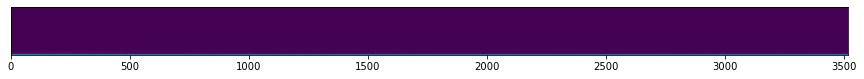

In [49]:
train_activations = learn.activation_logging.activations["layer_0"]
visualize_color_map(train_activations)

In the above figure, we have batches along the x-axis and counts of activations along the y-axis. *The y-axis is inverted here; meaning highest count is at the bottom and lowest count is at the top.* the color scale can be interpreted as blue is near zero and yellow corresponds to highest count. In the above figure, with absolute counts, we cannot really make out properly what's happening. There seems to be a really bright patch in the bottom left and over time it's somewhat fading.

However, if we take a log of these counts and then plot the activations, we can see the picture much more clearly as below.

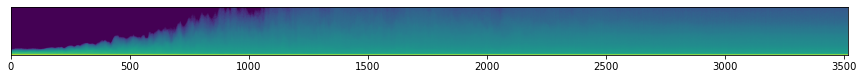

In [50]:
train_activations = learn.activation_logging.activations["layer_0"]
visualize_color_map(train_activations, with_log = True)

Here we can see that across 5 epochs, after every 700 batches i.e. 1 epoch how the training is progressing.

- In first epoch, there were a lot of near-zero/negative activations.
- In later epochs the concentration of positive activations started rising.
- With every subsequent epoch, the concentration of positive activations more or less has stabilized and there's not much of a difference which is good from a training perspective.

If the activations stayed near zero or there was a continuous up and down i.e. peaks and valleys in the blue region, that would mean the training is instable. We can train a model with the absence of batchnorm and see how that graph looks like. Let's see

In [51]:
# Instantiate a learner without batch normalization with the activation_logging callback and train for some epochs
learn = Learner(dls, basic_cnn_model(bn = False), 
                loss_func=F.cross_entropy, 
                metrics=accuracy, 
                cbs = activation_logging())

learn.fit_one_cycle(5, lr_max = 6e-2)    

epoch,train_loss,valid_loss,accuracy,time
0,0.569560,0.674637,0.796933,00:15
1,0.496504,0.450199,0.884333,00:15
2,0.293660,0.273755,0.921933,00:20
3,0.141593,0.170080,0.954067,00:37
4,0.093805,0.113469,0.969467,00:35


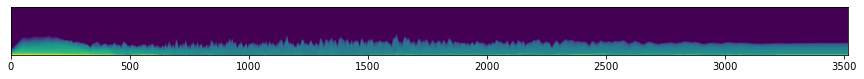

In [52]:
train_activations = learn.activation_logging.activations["layer_0"]
visualize_color_map(train_activations, with_log = True)

As we can see the training is now very bumpy and unstable. Let us only focus on the first epoch for now and see it's graph

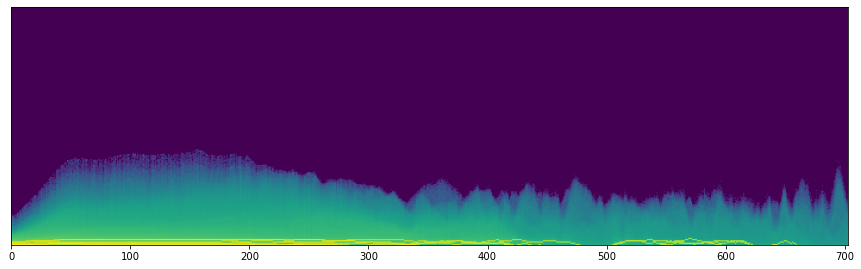

In [54]:
train_activations = learn.activation_logging.activations["layer_0"][:len(learn.dls.train)]
visualize_color_map(train_activations, with_log = True)

In the first epoch, after every batch, we can observe the activations are flipping a lot which means that backprop is tuning the weights in a very crazy manner and forward passes are subsequently becoming very unstable. This is just to demonstrate how `batch_norm` can help stabilize/smoothen the training process so we don't have to worry about such issues.

# fastai convenience function for color dimension

Internally fastai offers a function to do this color mapping without having to write any of the code we wrote above. What we did above was actually a decomposition of what fastai is doing internally. 

Let us have a look at how we can use internal functions to do this 

In [59]:
learn = Learner(dls, basic_cnn_model(bn = True), 
                loss_func=F.cross_entropy, 
                metrics=accuracy, 
                cbs = ActivationStats(with_hist=True))

learn.fit_one_cycle(1, lr_max = 6e-2)    

epoch,train_loss,valid_loss,accuracy,time
0,0.057763,0.057509,0.981733,00:44


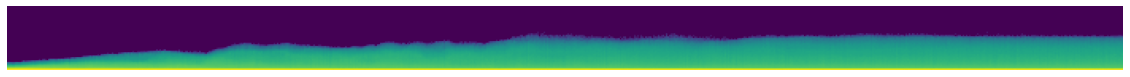

In [62]:
learn.activation_stats.color_dim(0, figsize = (20, 5))

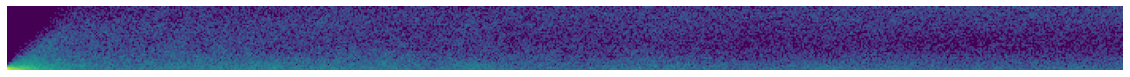

In [67]:
learn.activation_stats.color_dim(8, figsize = (20, 5))

So we can simply call the `ActivationStats` callback function as we instantiate the learner and we can get the color dimension plot pertaining to any layer of our choice. However, this will hook all the modules having trainable params so the overhead might be high. If you only want to hook one particular layer, you can do that by creating a custom callback as we did above.

I hope this post helped you get a better idea about the color dimension and how activations can help us understand how a model is getting trained across batches. If you liked what you read, you could read my [other posts here](https://elisonsherton.github.io/archive.html) and connect with me on [twitter here](https://twitter.com/ElisonSherton). 

# References

1. [wandb fastbook session link](https://community.wandb.ai/t/week-13-discussion-thread/390)
2. [colorful dimension by stefano giomo](https://forums.fast.ai/t/the-colorful-dimension/42908)
2. [Fastai callbacks documentation](https://docs.fast.ai/callback.core.html#Callback)
3. [Fastai hooks documentation](https://docs.fast.ai/callback.hook.html)
4. [fastbook chapter 13 on convolutions](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb)